In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
    save_img,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:8', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:9', device_type='GPU')]


Load Data 

In [4]:
current_path = os.getcwd()
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

**LABELS**
- **MEL** - Melanoma
- **NV** - Melanocytic nevus
- **BCC** - Basal cell carcinoma
- **AK** - Actinic keratosis
- **BKL** - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- **DF** - Dermatofibroma
- **VASC** - Vascular lesion
- **SCC** - Squamous cell carcinoma
- **UNK** - None of the above


In [5]:
# ground_truth_table.drop('UNK',axis=1,inplace=True)
print(ground_truth_table.head())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [6]:
print(training_metadata_table.head())

          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male


In [7]:
print(training_metadata_table.shape)
print(ground_truth_table.shape)

(25331, 5)
(25331, 10)


In [8]:
training_metadata_table.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64

In [9]:
training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)
training_metadata_table.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
training_metadata_table.isnull().sum()

/tmp/ipykernel_224214/174194398.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)


image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64

Text(0.5, 1.0, 'Gender of Patient')

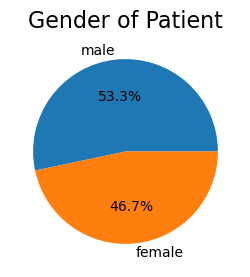

In [10]:
bar, ax = plt.subplots(figsize = (3,3))
plt.pie(training_metadata_table['sex'].value_counts(), labels = training_metadata_table['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

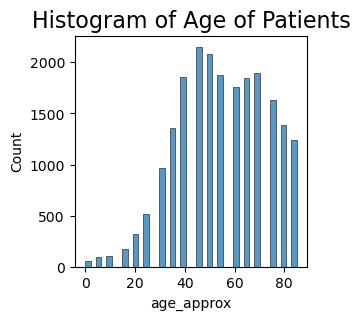

In [11]:
bar, ax = plt.subplots(figsize=(3, 3))
sns.histplot(training_metadata_table['age_approx'])
plt.title('Histogram of Age of Patients', size=16)

In [12]:
ground_truth_table.replace(['NaN', 'N/A', 'NA', 'n/a', 'n.a.', 'N#A', 'n#a', '?'], 'other', inplace=True)
missing_df =  ground_truth_table.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_df["% of Missing Values"] = round((missing_df["Total No. of Missing Values"]/len( ground_truth_table))*100,2)
missing_df

,Total No. of Missing Values,% of Missing Values
image,0,0.0
MEL,0,0.0
NV,0,0.0
BCC,0,0.0
AK,0,0.0
BKL,0,0.0
DF,0,0.0
VASC,0,0.0
SCC,0,0.0
UNK,0,0.0


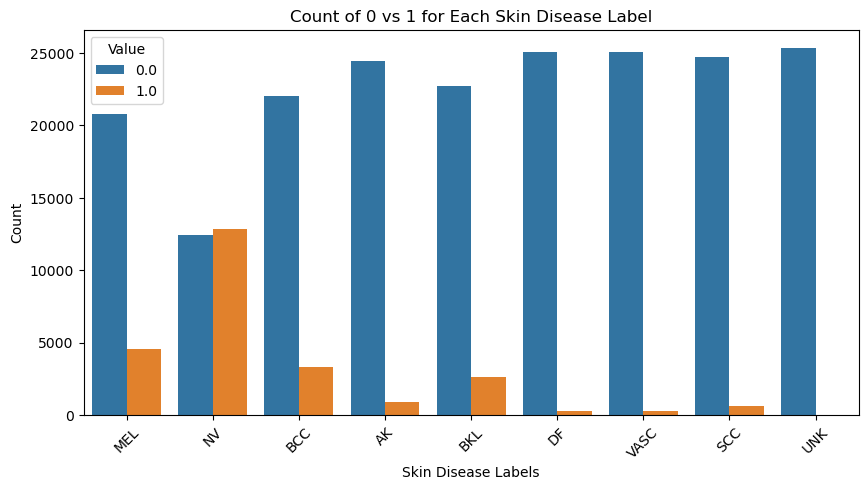

In [13]:
melted_df = pd.melt(ground_truth_table, id_vars=['image'], var_name='Label', value_name='Value')

plt.figure(figsize=(10, 5)) 
sns.countplot(x='Label', hue='Value', data=melted_df)
plt.title('Count of 0 vs 1 for Each Skin Disease Label')
plt.xlabel('Skin Disease Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

In [14]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)
ground_truth_table.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [15]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

lesion_type_mapping = {lesion: idx+1 for idx, lesion in enumerate(classes)}

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)

merged_data = pd.merge(training_metadata_table, ground_truth_table[['image', 'label']], on='image', how='left')

merged_data['lesion_type'] = merged_data['label']
merged_data['lesion_type_id'] = merged_data['lesion_type'].map(lesion_type_mapping)

merged_data = merged_data.drop(columns=['label'])

merged_data.head()

,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id
0,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female,NV,1
1,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female,NV,1
2,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female,NV,1
3,ISIC_0012656_downsampled,45.0,posterior torso,MSK4_0011172,male,NV,1
4,ISIC_0012657_downsampled,20.0,upper extremity,MSK4_0011173,female,NV,1


Total images of NV : 12875
Total images of BCC : 3323
Total images of AK : 867
Total images of BKL : 2624
Total images of DF : 239
Total images of VASC : 253
Total images of SCC : 628
Total images of MEL : 4522


/tmp/ipykernel_224214/2760195501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")


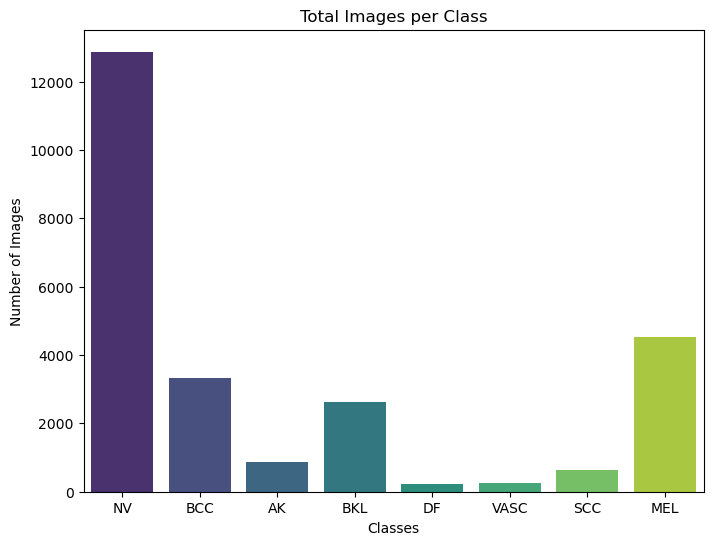

In [16]:
image_counts = {class_name: len(ground_truth_table[ground_truth_table[class_name] > 0]) for class_name in classes}

# Print the total images for each class
for class_name in classes:
    print(f"Total images of {class_name} : {image_counts[class_name]}")

plt.figure(figsize=(8, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")
plt.title('Total Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [17]:
lesion_image_count = merged_data.groupby('lesion_id').count()

lesion_single_image = lesion_image_count[lesion_image_count['image'] == 1]

lesion_single_image.reset_index(inplace=True)

lesion_single_image.head()

,lesion_id,image,age_approx,anatom_site_general,sex,lesion_type,lesion_type_id
0,BCN_0000013,1,1,1,1,1,1
1,BCN_0000020,1,1,1,1,1,1
2,BCN_0000039,1,1,1,1,1,1
3,BCN_0000053,1,1,1,1,1,1
4,BCN_0000059,1,1,1,1,1,1


In [18]:
# Identify lesion_ids that have only one image
unique_list = list(lesion_single_image['lesion_id'])

def find_duplicates(x):
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

merged_data['duplicates'] = merged_data['lesion_id']

merged_data['duplicates'] = merged_data['duplicates'].apply(find_duplicates)

merged_data.tail()


,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id,duplicates
21311,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,2,has_duplicates
21312,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,4,has_duplicates
21313,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,8,has_duplicates
21314,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,1,has_duplicates
21315,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,4,has_duplicates


In [19]:
merged_data['duplicates'].value_counts()

duplicates
has_duplicates    15959
no_duplicates      5357
Name: count, dtype: int64

In [20]:
no_duplicate_data = merged_data[merged_data['duplicates'] == 'no_duplicates']
no_duplicate_data.shape

(5357, 8)

In [21]:
y = no_duplicate_data['lesion_type']

_, val_data = train_test_split(no_duplicate_data, test_size=0.17, random_state=101, stratify=y)

print(val_data.shape)

print(val_data['lesion_type'].value_counts())

(911, 8)
lesion_type
NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: count, dtype: int64


In [22]:
# split into train or validation
def find_val_rows(x):
    val_list = list(val_data['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


merged_data['train_or_val'] = merged_data['image']
merged_data['train_or_val'] = merged_data['train_or_val'].apply(find_val_rows)
   
train_data = merged_data[merged_data['train_or_val'] == 'train']


print(len(train_data))
print(len(val_data))

20405
911


In [23]:
print(train_data['lesion_type'].value_counts())
print(val_data['lesion_type'].value_counts())

lesion_type
NV      9128
MEL     4027
BCC     3185
BKL     2188
AK       831
SCC      604
DF       228
VASC     214
Name: count, dtype: int64
lesion_type
NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: count, dtype: int64


In [24]:
base_dir = current_path + '/ISIC2019Dataset/ISIC_2019_Images/'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

# if not os.path.exists(train_dir):
#     os.mkdir(train_dir)

# if not os.path.exists(val_dir):
#     os.mkdir(val_dir)

# for c in classes:
#     # folders inside train_dir
#     class_train_dir = os.path.join(train_dir, c)
#     if not os.path.exists(class_train_dir):
#         os.mkdir(class_train_dir)

#     # folders inside val_dir
#     class_val_dir = os.path.join(val_dir, c)
#     if not os.path.exists(class_val_dir):
#         os.mkdir(class_val_dir)

# print("Folders created successfully!")

In [25]:
train_data

,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id,duplicates,train_or_val
0,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female,NV,1,no_duplicates,train
1,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female,NV,1,no_duplicates,train
2,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female,NV,1,no_duplicates,train
4,ISIC_0012657_downsampled,20.0,upper extremity,MSK4_0011173,female,NV,1,no_duplicates,train
5,ISIC_0012658_downsampled,40.0,posterior torso,MSK4_0010465,male,NV,1,no_duplicates,train
...,...,...,...,...,...,...,...,...,...
21311,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,2,has_duplicates,train
21312,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,4,has_duplicates,train
21313,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,8,has_duplicates,train
21314,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,1,has_duplicates,train


In [69]:
# merged_data.set_index('image', inplace=True)
# folder = os.listdir(current_path + training_directory_path)

# train_list = list(train_data['image'])
# val_list = list(val_data['image'])



# for image in train_list:
    
#     fname = image + '.jpg'
#     label = merged_data.loc[image,'lesion_type']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(train_dir, label, fname)
#         print(src)
#         print(dst)
#         shutil.copyfile(src, dst)



# for image in val_list:
    
#     fname = image + '.jpg'
#     label = merged_data.loc[image,'lesion_type']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(val_dir, label, fname)
#         shutil.copyfile(src, dst)


VGG16 Model

In [26]:
print("Train directory:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")

print("\nValidation directory:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(val_dir, cls)))} images")

Train directory:
NV: 9228 images
BCC: 9220 images
AK: 9060 images
BKL: 9202 images
DF: 8436 images
VASC: 7918 images
SCC: 8606 images
MEL: 9204 images

Validation directory:
NV: 623 images
BCC: 60 images
AK: 14 images
BKL: 107 images
DF: 7 images
VASC: 8 images
SCC: 18 images
MEL: 74 images


In [71]:
# num_aug_images_wanted = 9200  
# batch_size = 50

# for img_class in classes:
    
#     aug_dir = os.path.join(base_dir, 'aug_dir')

#     if os.path.exists(aug_dir):
#         shutil.rmtree(aug_dir)
    
#     os.mkdir(aug_dir)
#     img_dir = os.path.join(aug_dir, 'img_dir') 
#     os.mkdir(img_dir)

#     img_list = os.listdir(os.path.join(train_dir, img_class))

#     for fname in img_list:
#         src = os.path.join(train_dir, img_class, fname)
#         dst = os.path.join(img_dir, fname)
#         shutil.copyfile(src, dst)

#     path = aug_dir
#     save_path = os.path.join(train_dir, img_class)  

#     num_aug_images_wanted = 9200  
#     batch_size = 50

#     datagen = ImageDataGenerator(
#         rotation_range=180,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='nearest'
#     )

#     aug_datagen = datagen.flow_from_directory(
#         path,
#         save_to_dir=save_path,
#         save_format='jpg',
#         target_size=(224, 224),
#         batch_size=batch_size
#     )

#     num_files = len(os.listdir(img_dir))
#     num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

#     for i in range(num_batches):
#         imgs, labels = next(aug_datagen)

#     shutil.rmtree(aug_dir)

# print("Augmentation complete for all classes!")

In [72]:
# num_train_samples = len(train_data)  
# num_val_samples = len(val_data)      

# train_batch_size = 20
# val_batch_size = 20

# # VGG16 requires 224x224 image size
# image_size = 224

# # steps per epoch
# train_steps = np.ceil(num_train_samples / train_batch_size)
# val_steps = np.ceil(num_val_samples / val_batch_size)

# # data augmentation and preprocessing
# datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input  # VGG16's preprocessing function
# )

# # load training and validation batches
# train_batches = datagen.flow_from_directory(
#     train_dir,
#     target_size=(image_size, image_size),
#     batch_size=train_batch_size
# )

# valid_batches = datagen.flow_from_directory(
#     val_dir,
#     target_size=(image_size, image_size),
#     batch_size=val_batch_size
# )

# test_batches = datagen.flow_from_directory(
#     val_dir,
#     target_size=(image_size, image_size),
#     batch_size=1,
#     shuffle=False
# )

# vgg16_model = VGG16()

# vgg16_model.summary()

In [73]:
# from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import categorical_accuracy
from keras.applications.mobilenet import preprocess_input
from keras.applications import MobileNet
from keras.layers import BatchNormalization
from sklearn.metrics import f1_score, recall_score, precision_score
import keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# VGG16 requires 224x224 image size
image_size = 224

# Dataset sizes
num_train_samples = len(train_data)
num_val_samples = len(val_data)

# Batch sizes
train_batch_size = 20
val_batch_size = 20

# Steps per epoch
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# Data Augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
#     rescale=1./255,
    # rotation_range=180,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # brightness_range=[0.5, 1.5],
    # zoom_range=0.6,
    # horizontal_flip=True,
    # vertical_flip=True,
    # fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     rescale=1./255,
    # brightness_range=[0.5, 1.5]
)

# Generate training and validation data
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    shuffle=True
)
valid_batches = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_batch_size
)

input_shape = (image_size, image_size, 3)
VGG_16_base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
base_model = MobileNet(include_top=False, input_shape=input_shape, weights='imagenet')


for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom layers on top of model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.35)(x)
x = BatchNormalization()(x)
predictions = Dense(8, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, recall_m, precision_m, f1_m])

# Define class weights to handle class imbalance
class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 5.0,  # MEL  # Increase sensitivity to melanoma
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0   # VASC
}

# checkpoint = ModelCheckpoint(os.path.join(current_path, 'vgg16_checkpoint.h5'), monitor='val_categorical_accuracy', verbose=1, 
#                              save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(os.path.join(current_path, 'mobilenet_checkpoint3.h5'), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, 
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Train the model
history = model.fit_generator(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks_list
)
# for i in range(5):
#     print(f'Training batch {i + 1} of 5...')
#     history = model.fit(
#     train_batches,
#     validation_data=valid_batches,
#     steps_per_epoch=train_steps,
#     validation_steps=val_steps,
#     epochs=5,
#     class_weight=class_weights,
#     callbacks=callbacks_list)
# #     model.save(os.path.join(current_path, f'vgg16_partial_trained_model_batch_{i + 1}.h5'))
#     model.save(os.path.join(current_path, f'mobilenet_partial_trained_model2_batch_{i + 1}.h5'))


# model.save(os.path.join(current_path, 'vgg16_full_model_after_training.h5'))

model.save(os.path.join(current_path, 'mobilenet_full_model_after_training3.h5'))


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/home/fall2019/qnd5128/miniconda3/envs/capstone_env_/lib/python3.10/site-packages/keras/api/preprocessing/image/__init__.py)

In [44]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.backend as K

# Verify available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set GPU memory growth to avoid allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Custom metrics definitions
def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# MobileNet requires 224x224 image size
image_size = 224

# Dataset sizes
num_train_samples = len(train_data)
num_val_samples = len(val_data)

# Batch sizes
train_batch_size = 20
val_batch_size = 20

# Steps per epoch
train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

# Data Augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generate training and validation data
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    shuffle=True,
    class_mode='categorical'
)
valid_batches = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    class_mode='categorical'
)

# Build the model using MobileNet as the base
input_shape = (image_size, image_size, 3)
base_model = MobileNet(include_top=False, input_shape=input_shape, weights='imagenet')

# Add custom layers on top of model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.35)(x)
x = BatchNormalization()(x)
predictions = Dense(8, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

# Define class weights to handle class imbalance
class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 5.0,  # MEL  # Increase sensitivity to melanoma
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0   # VASC
}

# Callbacks for saving the best model and reducing learning rate on plateau
checkpoint = ModelCheckpoint('mobilenet_checkpoint4.keras', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Train the model
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=int(train_steps),
    validation_steps=int(val_steps),
    epochs=30,
    callbacks=callbacks_list
)

# Save the final model
model.save('mobilenet_full_model_after_training4.keras')


Num GPUs Available:  10
Found 70874 images belonging to 8 classes.
Found 911 images belonging to 8 classes.
Epoch 1/30


/home/fall2019/qnd5128/miniconda3/envs/capstone_env_/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730408088.911724 3793674 service.cc:148] XLA service 0x556fa79ada10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730408088.912414 3793674 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730408088.912429 3793674 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730408088.912432 3793674 service.cc:156]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1730408088.912435 3793674 service.cc:156]   StreamExecuto

   1/1021 ━━━━━━━━━━━━━━━━━━━━ 13:57:37 49s/step - categorical_accuracy: 0.1500 - loss: 2.7970

I0000 00:00:1730408124.308369 3793674 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  26/1021 ━━━━━━━━━━━━━━━━━━━━ 1:58 119ms/step - categorical_accuracy: 0.1388 - loss: 2.7052

2024-10-31 16:55:30.722930: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=0,k4=3,k5=3,k6=3,k7=2} for conv (f16[14,112,112,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[14,225,225,4]{3,2,1,0}, f16[32,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-31 16:55:30.723180: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv (f16[14,112,112,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[14,225,225,4]{3,2,1,0}, f16[32,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", b

 989/1021 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - categorical_accuracy: 0.2542 - loss: 2.2615

KeyboardInterrupt: 

In [42]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
import tensorflow.keras.backend as K

# Verify available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set GPU memory growth to avoid allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Custom metrics definitions
def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# MobileNet requires 224x224 image size
image_size = 229

# Dataset sizes
num_train_samples = len(train_data)
num_val_samples = len(val_data)

# Batch sizes
train_batch_size = 20
val_batch_size = 20

# Steps per epoch
train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

# Data Augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generate training and validation data
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    shuffle=True,
    class_mode='categorical'
)
valid_batches = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    class_mode='categorical'
)

# Build the model using MobileNet as the base
input_shape = (image_size, image_size, 3)
base_model = Xception(include_top=False, input_shape=input_shape, weights='imagenet')

# Add custom layers on top of model
x = base_model.layers[-2].output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
predictions = Dense(8, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)
print(f"Xception Layers: {len(model.layers)}")

#unfreeze the last 20 layers
for layer in model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, recall_m, precision_m, f1_m, top_3_accuracy])

# Define class weights to handle class imbalance
class_weights = {
    0: 1,  # AK
    1: 1,  # BCC
    2: 1,  # BKL
    3: 1,  # DF
    4: 3,  # MEL
    5: 1,  # NV
    6: 1,  # SCC
    7: 1   # VASC
}

# Function to compute sample weights
def compute_sample_weights(labels, class_weights):
    sample_weights = np.array([class_weights[np.argmax(label)] for label in labels])
    return sample_weights

# Generator that yields sample weights
def generator_with_sample_weights(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = compute_sample_weights(y, class_weights)
        yield x, y, sample_weights

# Wrap your generators
train_batches_with_weights = generator_with_sample_weights(train_batches, class_weights)
valid_batches_with_weights = generator_with_sample_weights(valid_batches, class_weights)


# Callbacks for saving the best model and reducing learning rate on plateau
checkpoint = ModelCheckpoint('xception_checkpoint2.keras', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
    train_batches_with_weights,
    validation_data=valid_batches_with_weights,
    steps_per_epoch=int(train_steps),
    validation_steps=int(val_steps),
    epochs=30,
    callbacks=callbacks_list
)

# Save the final model
model.save('xception_full_model_after_training2.keras')


Num GPUs Available:  10
Found 70874 images belonging to 8 classes.
Found 911 images belonging to 8 classes.
Xception Layers: 135
Epoch 1/30
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_accuracy: 0.2884 - f1_m: 0.1966 - loss: 2.5618 - precision_m: 0.3781 - recall_m: 0.1364 - top_3_accuracy: 0.5996
Epoch 1: val_categorical_accuracy improved from -inf to 0.72338, saving model to xception_checkpoint2.keras
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 190s 174ms/step - categorical_accuracy: 0.2884 - f1_m: 0.1967 - loss: 2.5614 - precision_m: 0.3782 - recall_m: 0.1365 - top_3_accuracy: 0.5997 - val_categorical_accuracy: 0.7234 - val_f1_m: 0.7193 - val_loss: 1.0813 - val_precision_m: 0.7955 - val_recall_m: 0.6608 - val_top_3_accuracy: 0.9341 - learning_rate: 1.0000e-05
Epoch 2/30
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - categorical_accuracy: 0.4643 - f1_m: 0.3938 - loss: 1.8741 - precision_m: 0.5979 - recall_m: 0.2980 - top_3_accuracy: 0.7846
Epoch 2: val_categorical_accuracy did not im

135

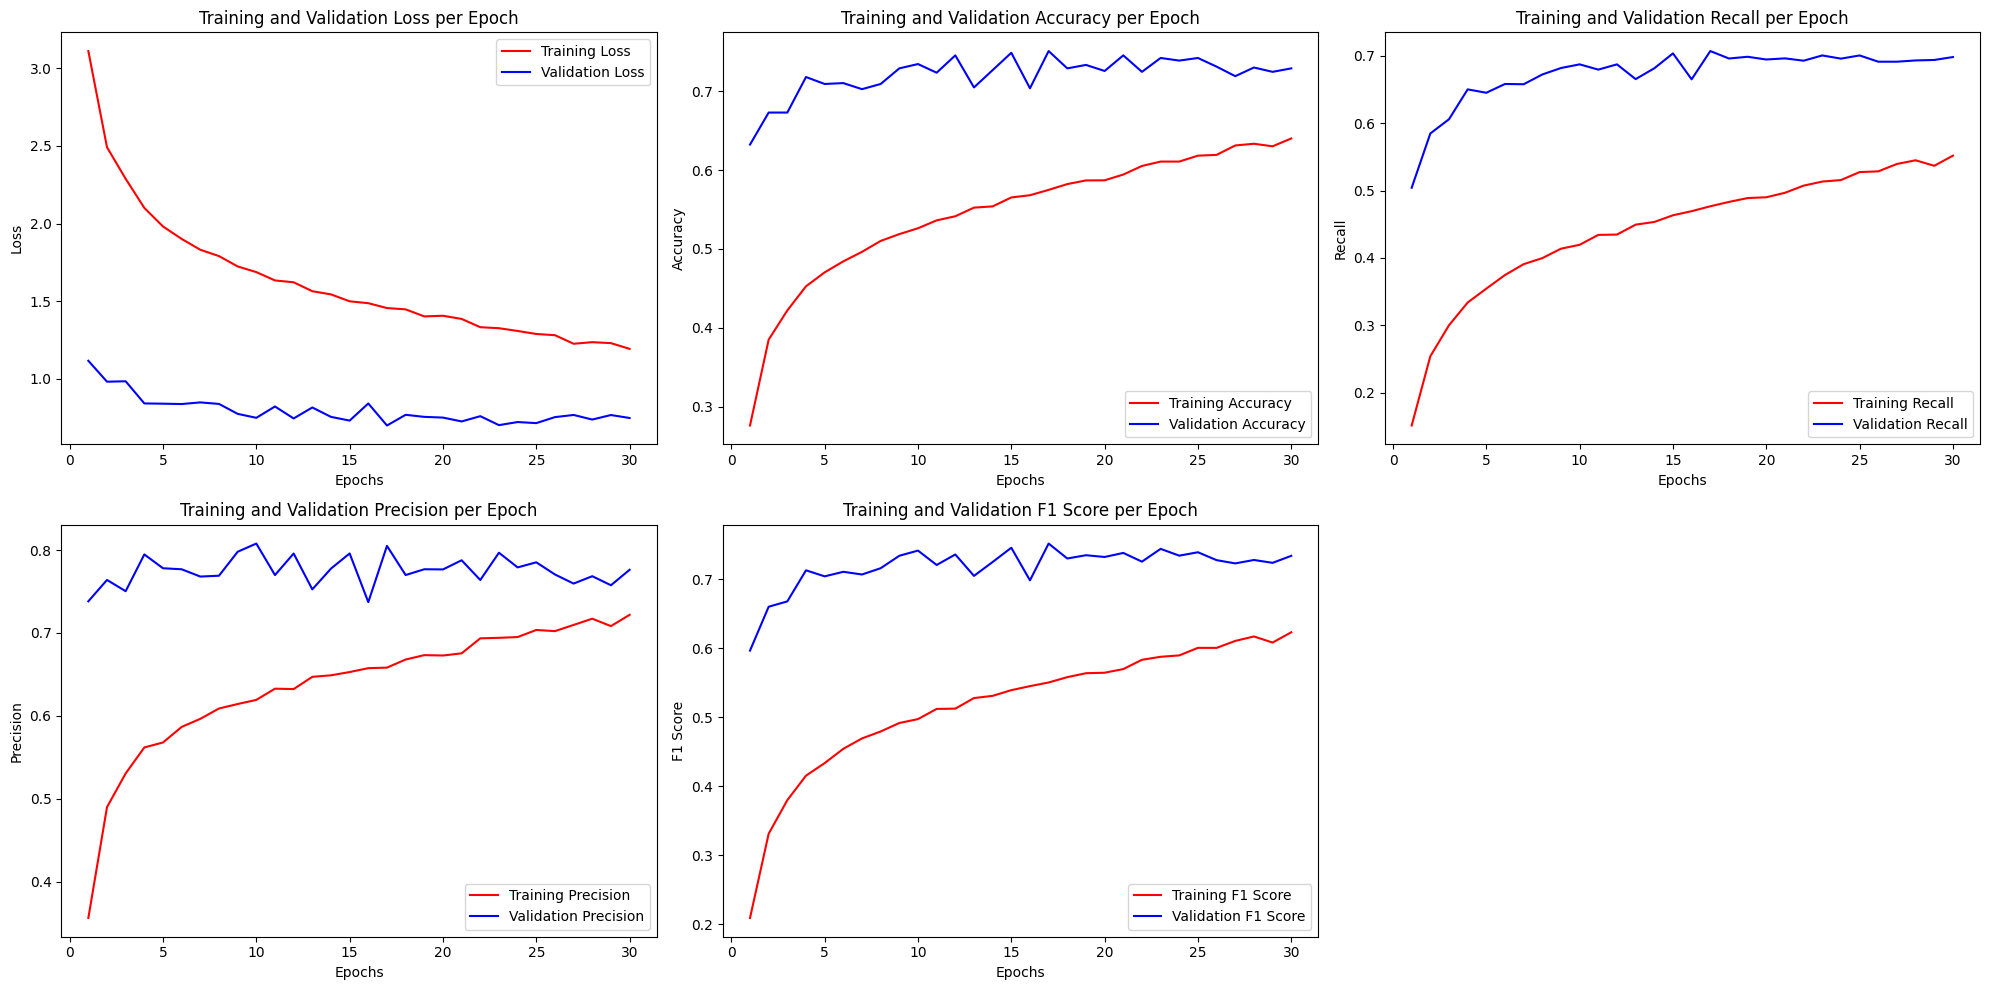

In [29]:
# Extract metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
train_precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
train_f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_loss.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_accuracy.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_recall.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_precision.png'))

# Plot F1 Score
plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_f1_score.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'all_metrics_plots.png'))
plt.show()

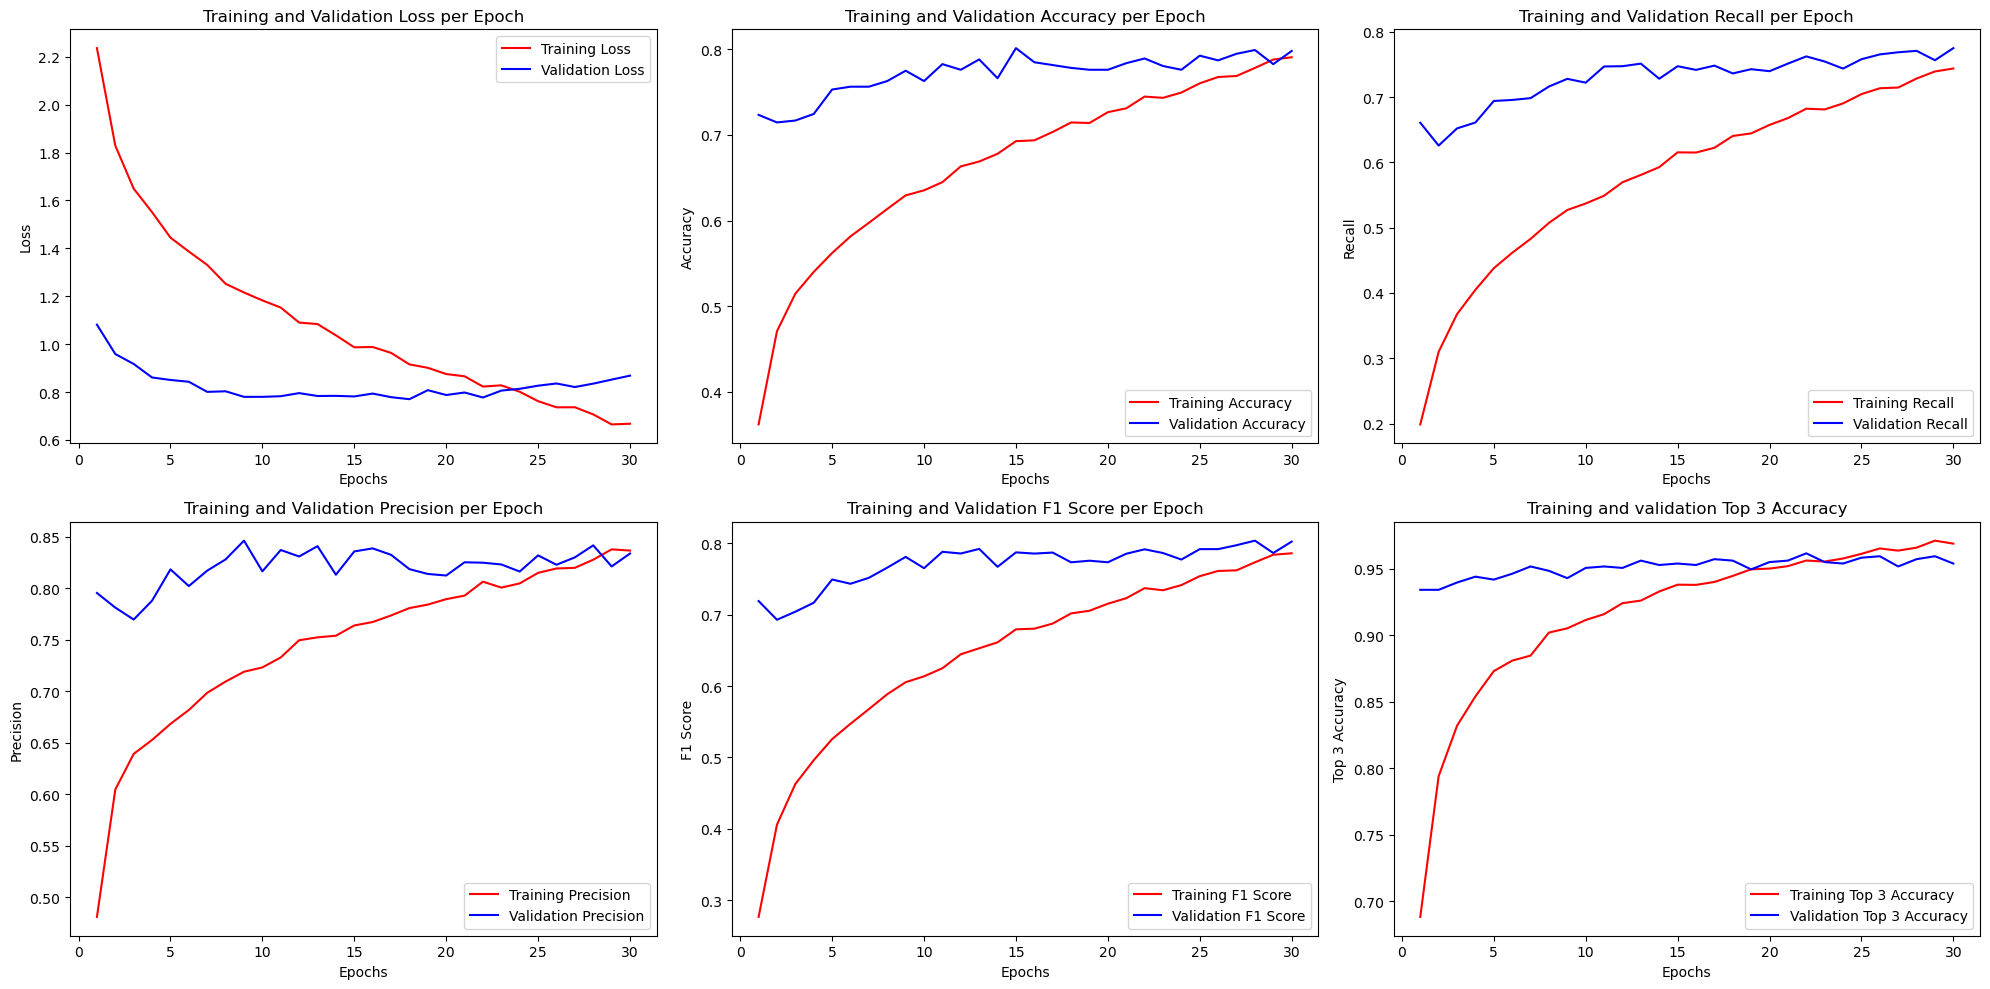

In [43]:
# Extract metrics from history for Xception
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
train_precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
train_f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'xception_training_validation_loss2.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'xception_training_validation_accuracy2.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'xception_training_validation_recall2.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'xception_training_validation_precision2.png'))

# Plot F1 Score
plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig(os.path.join(current_path, 'xception_training_validation_f1_score2.png'))

# Plot Top 3 Accuracy
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top3_acc, 'r-', label='Training Top 3 Accuracy')
plt.plot(epochs, val_top3_acc, 'b-', label='Validation Top 3 Accuracy')
plt.title('Training and validation Top 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 3 Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'xception_training_validation_top3_acc2.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'xception_all_metrics_plots2.png'))
plt.show()

In [44]:

predictions = model.predict(valid_batches, steps=len(val_data), verbose=1)


/home/fall2019/qnd5128/miniconda3/envs/capstone_env_/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


911/911 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step  


2024-11-01 16:39:36.396095: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/fall2019/qnd5128/miniconda3/envs/capstone_env_/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [47]:
valid_batches.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

Confusion matrix, without normalization
[[  0   1   2   0   0  11   0   0]
 [  0   3   5   0   8  40   3   1]
 [  2   7  15   0  13  68   1   1]
 [  0   1   1   0   0   5   0   0]
 [  1   5  11   1   6  50   0   0]
 [ 17  43  58   1  62 427  11   4]
 [  1   2   2   0   2  11   0   0]
 [  0   0   0   0   1   7   0   0]]


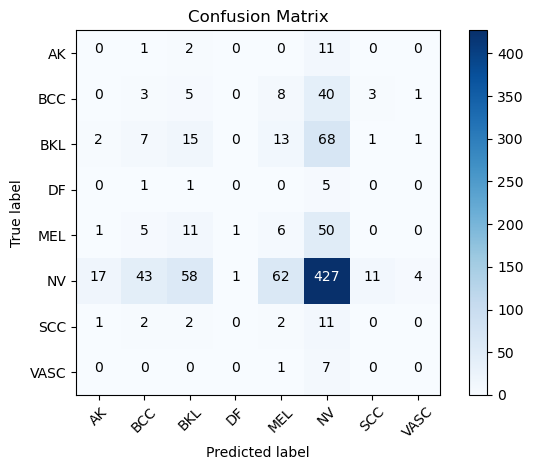

In [45]:
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

test_labels = valid_batches.classes
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'VASC']
cm = metrics.confusion_matrix(test_labels, predictions.argmax(axis=1))

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [46]:
from sklearn.metrics import classification_report

y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = valid_batches.classes

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

          AK       0.00      0.00      0.00        14
         BCC       0.05      0.05      0.05        60
         BKL       0.16      0.14      0.15       107
          DF       0.00      0.00      0.00         7
         MEL       0.07      0.08      0.07        74
          NV       0.69      0.69      0.69       623
         SCC       0.00      0.00      0.00        18
        VASC       0.00      0.00      0.00         8

    accuracy                           0.50       911
   macro avg       0.12      0.12      0.12       911
weighted avg       0.50      0.50      0.50       911



46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step
Confusion matrix, without normalization
[[  1   1   0   0   1  10   1   0]
 [  0   5  11   0  10  33   0   1]
 [  3   7   9   0   9  72   5   2]
 [  0   0   0   0   1   5   1   0]
 [  2   3  12   1   9  47   0   0]
 [ 14  42  59   1  61 435   8   3]
 [  1   3   1   0   1  12   0   0]
 [  0   1   2   0   0   5   0   0]]


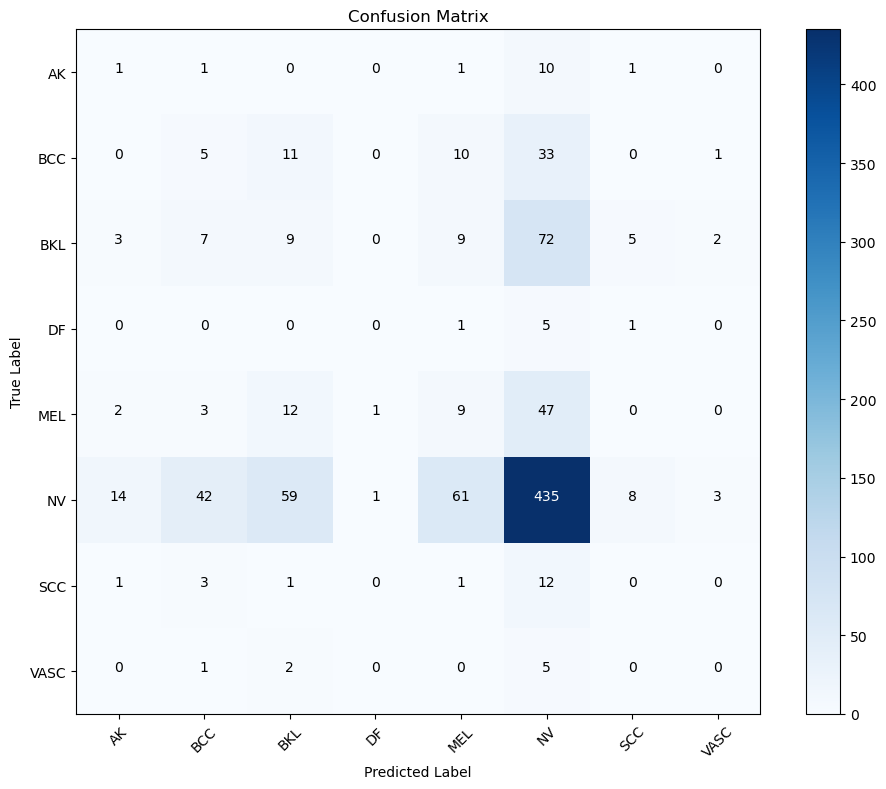

Normalized confusion matrix
[[0.07142857 0.07142857 0.         0.         0.07142857 0.71428571
  0.07142857 0.        ]
 [0.         0.08333333 0.18333333 0.         0.16666667 0.55
  0.         0.01666667]
 [0.02803738 0.06542056 0.08411215 0.         0.08411215 0.6728972
  0.04672897 0.01869159]
 [0.         0.         0.         0.         0.14285714 0.71428571
  0.14285714 0.        ]
 [0.02702703 0.04054054 0.16216216 0.01351351 0.12162162 0.63513514
  0.         0.        ]
 [0.02247191 0.06741573 0.09470305 0.00160514 0.09791332 0.69823435
  0.01284109 0.00481541]
 [0.05555556 0.16666667 0.05555556 0.         0.05555556 0.66666667
  0.         0.        ]
 [0.         0.125      0.25       0.         0.         0.625
  0.         0.        ]]


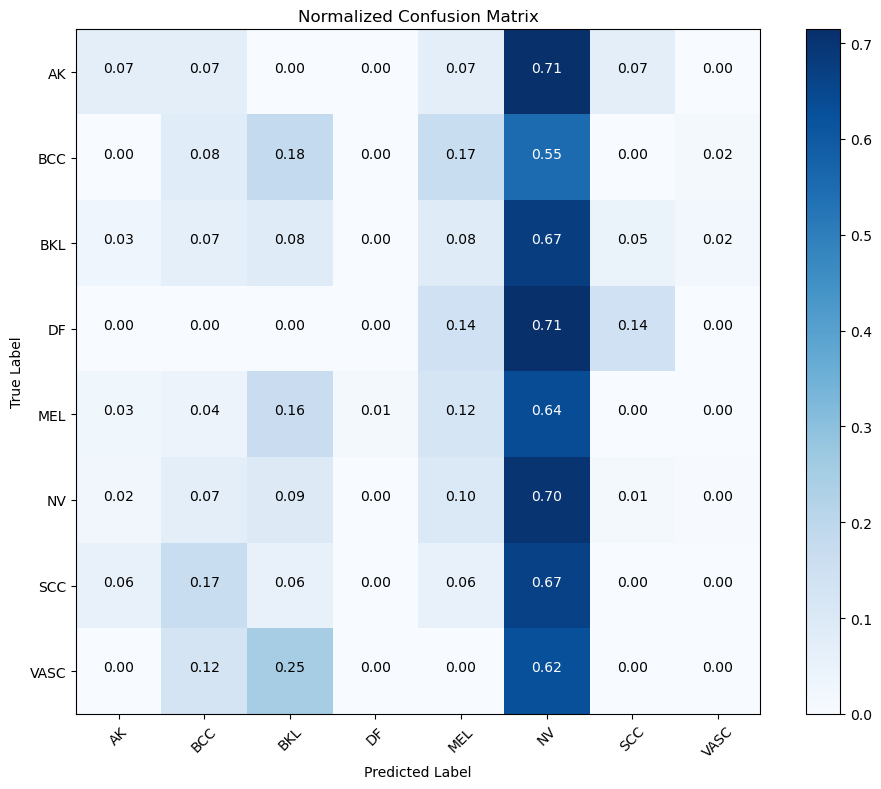

              precision    recall  f1-score   support

          AK       0.05      0.07      0.06        14
         BCC       0.08      0.08      0.08        60
         BKL       0.10      0.08      0.09       107
          DF       0.00      0.00      0.00         7
         MEL       0.10      0.12      0.11        74
          NV       0.70      0.70      0.70       623
         SCC       0.00      0.00      0.00        18
        VASC       0.00      0.00      0.00         8

    accuracy                           0.50       911
   macro avg       0.13      0.13      0.13       911
weighted avg       0.51      0.50      0.50       911

Overall Accuracy: 0.5038


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'model' is your trained model and 'valid_batches' is your validation data generator

# Generate predictions
predictions = model.predict(valid_batches, steps=val_steps, verbose=1)

# Convert predictions to label indices
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the generator
y_true = valid_batches.classes

# Get the class labels
class_labels = list(valid_batches.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix')

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Optionally, you can save the report to a file
with open('classification_report.txt', 'w') as f:
    f.write(report)

# Calculate and print overall accuracy
accuracy = metrics.accuracy_score(y_true, y_pred)
print(f'Overall Accuracy: {accuracy:.4f}')
